## Wellhead Pressure Prediction
Anadarko Petroleum Corporation

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras, set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline
np.random.seed(42)
set_random_seed(42)

In [6]:
class WellheadPressurePrediction:
    def __init__(self, df, sample_size):
        self.df = df
        self.sample_size = sample_size
        self.predictions = np.empty(0)
        self.actuals = np.empty(0)
        self.test_rmse = []
        self.train_rmse = []
        self.setup()
        self.preprocess()
        self.normalize()
        self.reshape()

    def setup(self):
        self.model = Sequential()
        self.model.add(Conv1D(10,3,input_shape=(self.sample_size,4), activation = 'relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(10,3, activation = 'relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Conv1D(10,3, activation = 'relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(SimpleRNN(10, return_sequences = True, dropout=0.2))
        self.model.add(SimpleRNN(10))
        self.model.add(Dense(1))
        self.model.compile(loss='mse', optimizer='adam')
        
    def train(self, x, y):
        early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=1, mode='min')
        self.model.fit(x, y, epochs=100, batch_size=200, verbose=0, callbacks=[early_stop])

    def predict(self, x):
        predictions = self.model.predict(x)
        return predictions
    
    def calculate_rmse(self, x, y, predictions):
        x = x.reshape((x.shape[0], -1))
        y = y.reshape((len(y), 1))
        predictions_inverted = np.concatenate((x, predictions), axis=1)
        predictions_inverted = self.scaler.inverse_transform(predictions_inverted)
        predictions_inverted = predictions_inverted[:,-1]
        invert_y = np.concatenate((x, y), axis=1)
        invert_y = self.scaler.inverse_transform(invert_y)
        invert_y = invert_y[:,-1]
        rmse = np.sqrt(mean_squared_error(invert_y, predictions_inverted))
        return rmse, predictions_inverted, invert_y
    
    def normalize(self):
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler = self.scaler.fit(self.dataset)
        self.normalized = self.scaler.transform(self.dataset)

    def reshape(self):
        self.x_data = self.normalized[:, 0:self.N_feature]
        self.y_data = self.normalized[:, self.N_feature]
        self.data = np.reshape(self.x_data, (self.x_data.shape[0], -1, 4))
    
    def preprocess(self):
        self.df['date_time']=pd.to_datetime(self.df.date_time.iloc[:])
        t = (self.df.date_time-self.df.date_time.iloc[0]).dt.total_seconds()
        self.df.loc[:,'new_time'] = t

        df1 = self.df[(self.df.prop_conc_1 > 0)]
        Nrow = df1.shape[0]
        Nrow1 = Nrow - sample_size
        data1 = df1[['prop_conc_1','bh_prop_conc','fr_conc_2','slurry_rate']]
        data2 = df1['wellhead_pressure_1']
        X = np.zeros((Nrow1, sample_size,4))
        Y = np.zeros(Nrow1)
        time_n = np.zeros((Nrow1,1))
        for i in range(0, Nrow1):
            X[i,:,:] = data1.iloc[i:(i+sample_size),:]
            Y[i] = data2.iloc[(i+sample_size-1)]
            time_n[i] = df1.new_time.iloc[i+sample_size]
        df2 = pd.DataFrame()
        for i in range(0, sample_size):
            col_name1 = "prop_conc(t-" + str(sample_size-1-i) + ")"
            df2[col_name1] = pd.Series(X[:,i,0])
        for i in range(0, sample_size):
            col_name2 = "bp_prop_conc(t-" + str(sample_size-1-i) + ")"
            df2[col_name2] = pd.Series(X[:,i,1])
        for i in range(0, sample_size):
            col_name3 = "fr_conc_2(t-" + str(sample_size-1-i) + ")"
            df2[col_name3] = pd.Series(X[:,i,2])
        for i in range(0, sample_size):
            col_name4 = "slurry_rate(t-" + str(sample_size-1-i) + ")"
            df2[col_name4] = pd.Series(X[:,i,3])
        df2['wh_pressure'] = Y
        dataset = df2.values
        self.N_feature = dataset.shape[1] - 1
        self.dataset = dataset.astype('float32')
        
    def plot_predictions(self):
        fig=plt.figure(figsize=(14, 21), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(411)
        plt.ylabel('Wellhead Pressure')
        plt.plot(self.actuals, 'g-', label='Actual')
        plt.plot(self.predictions, 'r-.', label='Predicted')
        plt.legend(loc='lower right', prop={'size': 10})
        plt.grid(axis='y', linestyle='--')

        plt.subplot(412)
        plt.ylabel('RMSE')
        plt.plot(self.train_rmse,'.-', label='Train')
        plt.plot(self.test_rmse,'.-', label='Test')
        plt.ylim(0)
        plt.legend()
        plt.grid(axis='y', linestyle='--')

In [27]:
wpp.actuals

array([], dtype=float64)

In [7]:
def load_data(file_name, stage_no):
    df = pd.read_csv(file_name)
    df = df[(df.stage_number == stage_no)]
    df = df[['date_time','prop_conc_1','bh_prop_conc','fr_conc_2','slurry_rate','wellhead_pressure_1']]
    return df

In [8]:
# Configuration
config = tf.ConfigProto(device_count = {'GPU':1, 'CPU':32})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [9]:
api = '4230133468'
file_name = '../Data/full' + api + '.csv'
stage_no = 2
prediction_length = 120 # seconds
sample_size = 120
df = load_data(file_name, stage_no)
wpp = WellheadPressurePrediction(df=df, sample_size=120)
stop = round(len(wpp.data) / prediction_length) * prediction_length - sample_size
interval = np.arange(sample_size, stop, prediction_length)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [29]:
# Train and Predict for each n minute window
import time 
test1_predictions=[]
test1=[]
rm1_test=[]
rm1_train=[]
#=[]
for index in interval:
    t1=time.time()
    #print(index)
    x_train = wpp.data[0:index, :, :]
    y_train = wpp.y_data[0:index]
    for i in y_train:
        Y.append(i)
        
    x_test = wpp.data[index+1:index+prediction_length, :, :]
    y_test = wpp.y_data[index+1:index+prediction_length]
    # Train and predict
    wpp.train(x_train, y_train)
    test_predictions = wpp.predict(x_test)
    train_predictions = wpp.predict(x_train)
    
    
    t2=time.time()
    print((t2-t1)/60)
    
    # Calculate rmse
    rmse_test, test_predictions_inverted, y_test_inverted = wpp.calculate_rmse(x_test, y_test, test_predictions)
    rmse_train, train_predictions_inverted, y_train_inverted = wpp.calculate_rmse(x_train, y_train, train_predictions)
    rm_test.append(rmse_test)
    rm_train.append(rmse_train)

    for i in test_predictions_inverted:
        test1_predictions.append(i)
    for i in y_test_inverted:
        test1.append(i)

        
    
    # Append results
#    wpp.predictions = np.append(wpp.predictions, test_predictions_inverted.tolist())
#    wpp.actuals = np.append(wpp.actuals, y_test_inverted.tolist())
#    wpp.test_rmse.append(rmse_test)
#    wpp.train_rmse.append(rmse_train)

0.0019380052884419758
0.0123658021291097
0.008572856585184732
0.01370319922765096
0.010277291138966879
0.037767370541890465
0.013753350575764973
0.036898406346639
0.049197828769683837
0.018499338626861574
0.021323529879252116
0.02217580477396647
0.0416109561920166
0.02578546603520711
0.03845253388086955
0.04004010359446208
0.032528050740559894
0.05911525090535482
0.04918113946914673
0.03628007570902506
0.05302472114562988
0.041026004155476886
0.09089273611704508
0.06041108369827271
0.0812333106994629
0.046290103594462076
0.05060160160064697
0.07069760163625081
0.05376003583272298
0.13865303993225098
0.056634326775868736
0.05932483673095703
0.06044449806213379
0.060916415850321454
0.08706602255503336
0.06422119537989299
0.09361629088719686
0.12252671718597412
0.09857954184214274
0.12926132281621297
0.07311166524887085
0.075718625386556
0.140541406472524
0.07936160564422608
0.11462230285008748
0.11438834269841512
0.11737963755925497
0.08658082087834676
0.12157417933146158
0.0911764740943

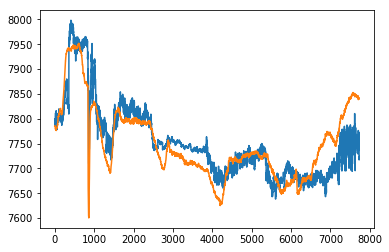

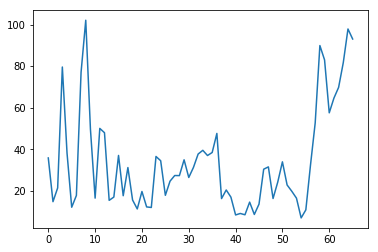

In [34]:
plt.clf()
plt.plot(test1_predictions)
#plt.plot(test1) # Model Uncertainty 
plt.show()
plt.clf()
plt.plot(rm_test)
plt.show()

In [20]:
#wpp.plot_predictions()
test_pred=wpp.predict(x_test)
pred=[]
for val in test_pred:
    pred.append(val[0])


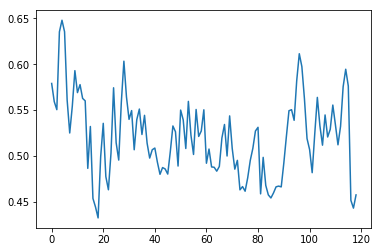

In [22]:
plt.clf()
plt.plot(pred)
plt.show()

In [25]:
test_predictions_inverted

array([7784.429 , 7776.5693, 7773.09  , 7806.7695, 7811.787 , 7806.797 ,
       7777.227 , 7762.994 , 7774.587 , 7789.974 , 7780.473 , 7783.9204,
       7777.967 , 7776.9067, 7747.685 , 7765.8037, 7734.681 , 7730.936 ,
       7726.2393, 7752.741 , 7767.1724, 7744.1416, 7738.4243, 7754.2983,
       7782.557 , 7758.774 , 7751.2744, 7776.1704, 7794.07  , 7778.626 ,
       7768.8975, 7772.692 , 7755.7417, 7768.78  , 7773.3496, 7762.3433,
       7770.6333, 7758.6   , 7752.142 , 7755.751 , 7756.4736, 7750.299 ,
       7745.1143, 7748.0327, 7747.4243, 7745.217 , 7755.0044, 7766.0337,
       7763.537 , 7748.689 , 7772.911 , 7768.6646, 7756.2847, 7776.6704,
       7762.0244, 7753.7026, 7773.167 , 7761.5005, 7763.868 , 7773.029 ,
       7749.9033, 7756.0435, 7748.3003, 7748.1655, 7746.469 , 7748.5044,
       7760.829 , 7766.6733, 7753.0337, 7770.3896, 7756.291 , 7747.346 ,
       7751.149 , 7738.389 , 7739.7974, 7737.7944, 7743.593 , 7751.15  ,
       7756.363 , 7763.8535, 7765.4497, 7736.6504, 